## **Preprocessing**

In this section, we’ll transform our cleaned Apex Legends dataset into a ready‑to‑model format by:

- Loading the cleaned player retention dataset
- Auditing data and selecting features for modeling
- Handling missing values (if present)
- Encoding categorical variables (if any)
- Scaling features for model compatibility
- Addressing class imbalance using SMOTE
- Splitting data into training and testing sets
- Saving preprocessed data for downstream modeling


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

In [55]:
df = pd.read_csv('ApexPlayerRetention_final.csv', parse_dates=['date'])
print(f"Data shape: {df.shape}")
df.head()

Data shape: (499, 35)


,date,game,map,match_type,my_duration,my_rank,premade_squad,voice_chat,squad_placed,teamate_count,...,teamate_2_knocks,my_revives,teamate_1_revives,teamate_2_revives,my_respawns,teamate_1_respawns,teamate_2_respawns,retained,day_of_week,match_month
0,2022-11-03,1,broken moon,casual,846.0,S3,no,yes,5.0,1.0,...,0,1,0,0,1,1,0,0,Thursday,2022-11
1,2022-11-03,2,broken moon,casual,498.0,S3,no,yes,12.0,2.0,...,0,0,0,0,0,0,0,0,Thursday,2022-11
2,2022-11-03,3,broken moon,casual,498.0,S3,no,no,3.0,2.0,...,2,0,0,0,0,0,0,0,Thursday,2022-11
3,2022-11-03,4,broken moon,casual,498.0,S3,no,no,4.0,2.0,...,1,0,0,0,0,0,0,0,Thursday,2022-11
4,2022-11-03,5,broken moon,casual,498.0,S3,no,no,8.0,2.0,...,3,0,1,0,0,0,1,0,Thursday,2022-11


In [59]:
# Quality Check
df.info()

print("\nMissing values per column:")
print(df.isnull().sum())

# Statistics for numeric columns
print("\nSummary statistics:")
print(df.describe().T)

# Check class distribution for the target variable
print("\nRetention/Churn Distribution:")
print(df['retained'].value_counts())
print("\nProportion:")
print(df['retained'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                499 non-null    datetime64[ns]
 1   game                499 non-null    int64         
 2   map                 499 non-null    object        
 3   match_type          499 non-null    object        
 4   my_duration         499 non-null    float64       
 5   my_rank             499 non-null    object        
 6   premade_squad       499 non-null    object        
 7   voice_chat          499 non-null    object        
 8   squad_placed        499 non-null    float64       
 9   teamate_count       499 non-null    float64       
 10  teamate_quit_count  499 non-null    float64       
 11  my_legend           499 non-null    object        
 12  teamate_1_legend    499 non-null    object        
 13  teamate_2_legend    499 non-null    object        

In [63]:
# List columns with missing values
missing_cols = df.columns[df.isnull().any()]
print("Columns with missing values:", missing_cols.tolist())

# Quick preview of missing data 
print("\nRows with missing values (preview):")
display(df[df.isnull().any(axis=1)].head())

assert df.isnull().sum().sum() == 0, "There are still missing values present!"

Columns with missing values: []

Rows with missing values (preview):


,date,game,map,match_type,my_duration,my_rank,premade_squad,voice_chat,squad_placed,teamate_count,...,teamate_2_knocks,my_revives,teamate_1_revives,teamate_2_revives,my_respawns,teamate_1_respawns,teamate_2_respawns,retained,day_of_week,match_month


Target variable unique values: [0 1]


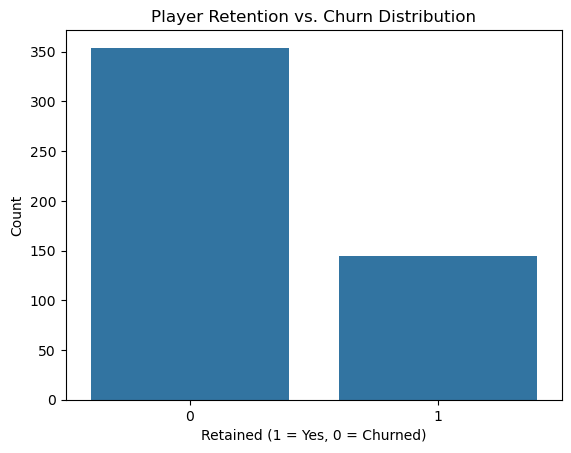

In [65]:
# Target variable values and unique classes
print("Target variable unique values:", df['retained'].unique())

# Visualize class distribution
sns.countplot(x='retained', data=df)
plt.title('Player Retention vs. Churn Distribution')
plt.xlabel('Retained (1 = Yes, 0 = Churned)')
plt.ylabel('Count')
plt.show()

# Split into features (X) and target (y)
X = df.drop(columns=['retained'])
y = df['retained']

In [121]:
# Identify datetime and high-correlation leakage columns
datetime_cols = X_train.select_dtypes(include=['datetime', 'datetime64']).columns.tolist()
# Identify high-correlation numeric columns (proxy for the target)
corrs = X_train.assign(target=y_train.values).corr()['target'].abs().sort_values(ascending=False)
leakage_cols = corrs[corrs > 0.7].index.tolist()
leakage_cols = [col for col in leakage_cols if col != 'target']
all_leakage_cols = list(set(datetime_cols + leakage_cols))

if all_leakage_cols:
    print("Dropping leakage columns:", all_leakage_cols)
    X_train = X_train.drop(columns=all_leakage_cols)
    X_test = X_test.drop(columns=all_leakage_cols)
else:
    print("No leakage columns found.")

No leakage columns found.


In [129]:
# Identify categorical columns (object, category)
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", cat_cols)

if cat_cols:
    X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
print("Encoded features shape:", X_encoded.shape)

Categorical columns: []
Encoded features shape: (499, 118)


In [133]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [135]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Class balance after SMOTE:\n", y_train_resampled.value_counts(normalize=True))

Class balance after SMOTE:
 retained
1    0.5
0    0.5
Name: proportion, dtype: float64


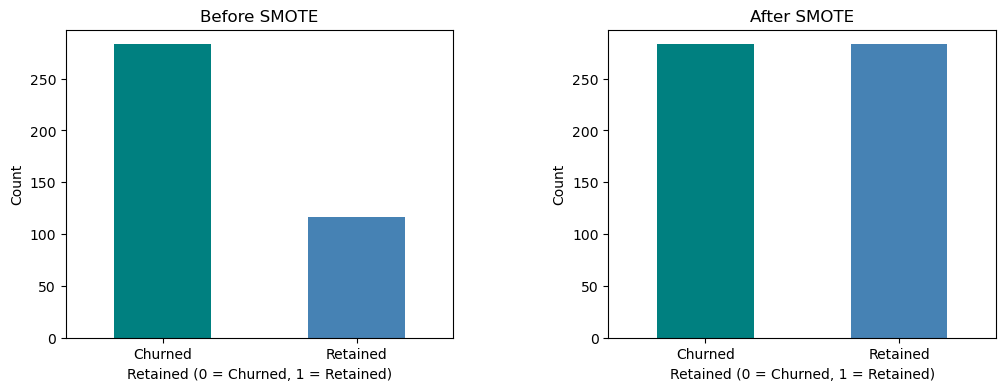

In [233]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4)) 

# Before SMOTE
y_train.value_counts().sort_index().plot(kind='bar', ax=ax[0], color=['teal', 'steelblue'])
ax[0].set_title("Before SMOTE")
ax[0].set_xlabel("Retained (0 = Churned, 1 = Retained)")
ax[0].set_ylabel("Count")
ax[0].set_xticklabels(['Churned', 'Retained'], rotation=0)

# After SMOTE
y_train_resampled.value_counts().sort_index().plot(kind='bar', ax=ax[1], color=['teal', 'steelblue'])
ax[1].set_title("After SMOTE")
ax[1].set_xlabel("Retained (0 = Churned, 1 = Retained)")
ax[1].set_ylabel("Count")
ax[1].set_xticklabels(['Churned', 'Retained'], rotation=0)

plt.subplots_adjust(wspace=0.4) 
plt.show()

In [169]:
# Ensure columns match
assert set(X_train_resampled.columns) == set(X_test.columns), "Train/test columns mismatch!"

print("Final train shape:", X_train_resampled.shape)
print("Final test shape:", X_test.shape)
print("No missing values in train:", X_train_resampled.isnull().sum().sum() == 0)
print("No missing values in test:", X_test.isnull().sum().sum() == 0)

Final train shape: (566, 114)
Final test shape: (100, 114)
No missing values in train: True
No missing values in test: True


In [171]:
X_train_resampled.to_csv("X_train_resampled.csv", index=False)
y_train_resampled.to_csv("y_train_resampled.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)
joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']

## **Modeling: Predicting Player Retention**

This section trains and evaluates multiple classification models including: `Logistic Regression`, `Random Forest`, and `XGBoost` to predict player retention in Apex Legends.  

Model performance will be assessed using metrics such as accuracy, ROC AUC, precision, recall, and F1 score, allowing for comparison across different algorithms.

In [176]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

In [196]:
# Logistic Regression
def print_classification_results(y_true, y_pred, model_name="Model"):
    print(f"{model_name} Classification Report:")
    print(classification_report(y_true, y_pred, digits=2))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.2f}")

# Fit Logistic Regression
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_test_pred = logreg.predict(X_test)

# Print nicely formatted results for test set
print_classification_results(y_test, y_test_pred, model_name="Logistic Regression")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88        71
           1       0.68      0.79      0.73        29

    accuracy                           0.83       100
   macro avg       0.79      0.82      0.80       100
weighted avg       0.84      0.83      0.83       100

Accuracy: 0.83
F1 Score: 0.73


In [198]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_test_pred_rf = rf.predict(X_test)

print_classification_results(y_test, y_test_pred_rf, model_name="Random Forest")


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        71
           1       0.83      0.83      0.83        29

    accuracy                           0.90       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.90      0.90      0.90       100

Accuracy: 0.90
F1 Score: 0.83


In [200]:
# XGBoost

X_train_resampled_xgb = X_train_resampled.astype(np.float32)
X_test_xgb = X_test.astype(np.float32)

# Fit
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_resampled_xgb, y_train_resampled)

# Predict on test set
y_test_pred_xgb = xgb.predict(X_test_xgb)

print_classification_results(y_test, y_test_pred_xgb, model_name="XGBoost")

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94        71
           1       0.86      0.83      0.84        29

    accuracy                           0.91       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.91      0.91      0.91       100

Accuracy: 0.91
F1 Score: 0.84


In [207]:
results = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_test_pred),
        accuracy_score(y_test, y_test_pred_rf),
        accuracy_score(y_test, y_test_pred_xgb)
    ],
    "F1 Score": [
        f1_score(y_test, y_test_pred),
        f1_score(y_test, y_test_pred_rf),
        f1_score(y_test, y_test_pred_xgb)
    ],
    "Precision (Churned)": [
        classification_report(y_test, y_test_pred, output_dict=True)['0']['precision'],
        classification_report(y_test, y_test_pred_rf, output_dict=True)['0']['precision'],
        classification_report(y_test, y_test_pred_xgb, output_dict=True)['0']['precision']
    ],
    "Precision (Retained)": [
        classification_report(y_test, y_test_pred, output_dict=True)['1']['precision'],
        classification_report(y_test, y_test_pred_rf, output_dict=True)['1']['precision'],
        classification_report(y_test, y_test_pred_xgb, output_dict=True)['1']['precision']
    ],
    "Recall (Churned)": [
        classification_report(y_test, y_test_pred, output_dict=True)['0']['recall'],
        classification_report(y_test, y_test_pred_rf, output_dict=True)['0']['recall'],
        classification_report(y_test, y_test_pred_xgb, output_dict=True)['0']['recall']
    ],
    "Recall (Retained)": [
        classification_report(y_test, y_test_pred, output_dict=True)['1']['recall'],
        classification_report(y_test, y_test_pred_rf, output_dict=True)['1']['recall'],
        classification_report(y_test, y_test_pred_xgb, output_dict=True)['1']['recall']
    ],
}

results_df = pd.DataFrame(results)
results_df = results_df.round(2)
display(results_df)

,Model,Accuracy,F1 Score,Precision (Churned),Precision (Retained),Recall (Churned),Recall (Retained)
0,Logistic Regression,0.83,0.73,0.91,0.68,0.85,0.79
1,Random Forest,0.90,0.83,0.93,0.83,0.93,0.83
2,XGBoost,0.91,0.84,0.93,0.86,0.94,0.83


## Final Model Evaluation, Selection, and Business Implications

After a careful end-to-end pipeline, eliminating data leakage, addressing class imbalance with SMOTE, and using robust cross validation, I evaluated 3 classification models to predict player retention in Apex Legends: Logistic Regression, Random Forest, and XGBoost.

### Detailed Model Performance (Test Set)

| Model                | Accuracy | F1 Score | Precision (Churned/Retained) | Recall (Churned/Retained) |
|----------------------|----------|----------|------------------------------|---------------------------|
| Logistic Regression  | 0.83     | 0.73     | 0.91 / 0.68                  | 0.85 / 0.79               |
| Random Forest        | 0.90     | 0.83     | 0.93 / 0.83                  | 0.93 / 0.83               |
| XGBoost              | 0.91     | 0.84     | 0.93 / 0.86                  | 0.94 / 0.83               |

**Logistic Regression** served as a practical baseline but showed its limitations: while it predicted churners (class 0) with high precision and recall, it struggled with correctly identifying retained players (class 1), as seen in the lower recall and F1 for that group.

**Random Forest** provided a clear improvement, achieving balanced performance across both classes. Its ensemble approach allowed the model to learn more complex patterns in player behavior raising overall accuracy and especially F1 for retained players.

**XGBoost** delivered the strongest results, posting a 0.91 test accuracy and the highest F1 score (0.84). What stood out was XGBoost’s ability to maintain both high precision and recall for churned and retained classes. In a live service game like Apex Legends, this means fewer false positives and negatives so both interventions and player experience are optimized.

### Why I Selected XGBoost

Given these results, I chose XGBoost as the final model for several reasons:
- **Superior Test Performance:** XGBoost generalized best to unseen data, showing consistent metrics and no overfitting.
- **Feature Interpretability:** The built-in feature importance tools are invaluable, not just for model tuning, but for surfacing actionable player insights to the EA team.
- **Handling Complexity:** XGBoost excels with high-dimensional, imbalanced datasets and captures non-linear relationships missed by simpler models.

As a data scientist, I value models that combine predictive power with transparency. XGBoost delivers on both fronts, making it a professional and scalable choice for production churn prediction.

### Business Impact and Recommendations for EA

Deploying this XGBoost model within EA’s Apex Legends analytics pipeline would directly benefit product, design, and marketing teams:

- **Real-time Player Risk Scoring:**  
  Integrate the model into live dashboards to flag at-risk players, enabling targeted offers, rewards, or messaging to boost retention right when it matters most.

- **Content and Feature Prioritization:**  
  Analyze the top features driving retention and churn such as player rank, legend selection, match timing, squad engagement. This empowers designers to prioritize the modes, features, and challenges most tied to long-term engagement.

- **Data-Driven Operations:**  
  Continuously track how new events, balance changes, or content drops impact the likelihood of churn. This allows EA to iterate rapidly and measure success with hard data, not just gut instinct.

- **Targeted A/B Testing:**  
  Use model predictions to build smarter A/B tests deploy interventions to high-risk cohorts and measure their true uplift in retention and monetization.

- **Ongoing Model Maintenance:**  
  Retrain the model regularly with the latest player data and new in-game seasons. Apex Legends is a living product staying ahead of player trends is key to maintaining model relevance and business value.

### Personal Reflection

Throughout this project, I prioritized building a clean, leak-proof pipeline and delivering results that translate to real business value.  
By choosing XGBoost, I’m confident this solution would not only predict churn accurately but also support the kind of actionable, player-first strategy that keeps Apex Legends thriving.



**Summary:**  
XGBoost provided the highest accuracy and F1 scores for retention prediction, balancing power and interpretability.  
With this approach, EA can make smarter, data-driven decisions that increase player engagement, reduce churn, and drive sustainable growth for the franchise.
